In [17]:
IMG_PATH = '/data/amazon/train-jpg/'
IMG_EXT = '.jpg'
TRAIN_DATA = '/data/amazon/train_v2.csv'

In [18]:
import numpy as np 
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# pal = sns.color_palette()
from collections import Counter, defaultdict
import cv2

In [19]:
df_train = pd.read_csv(TRAIN_DATA)
df_train.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

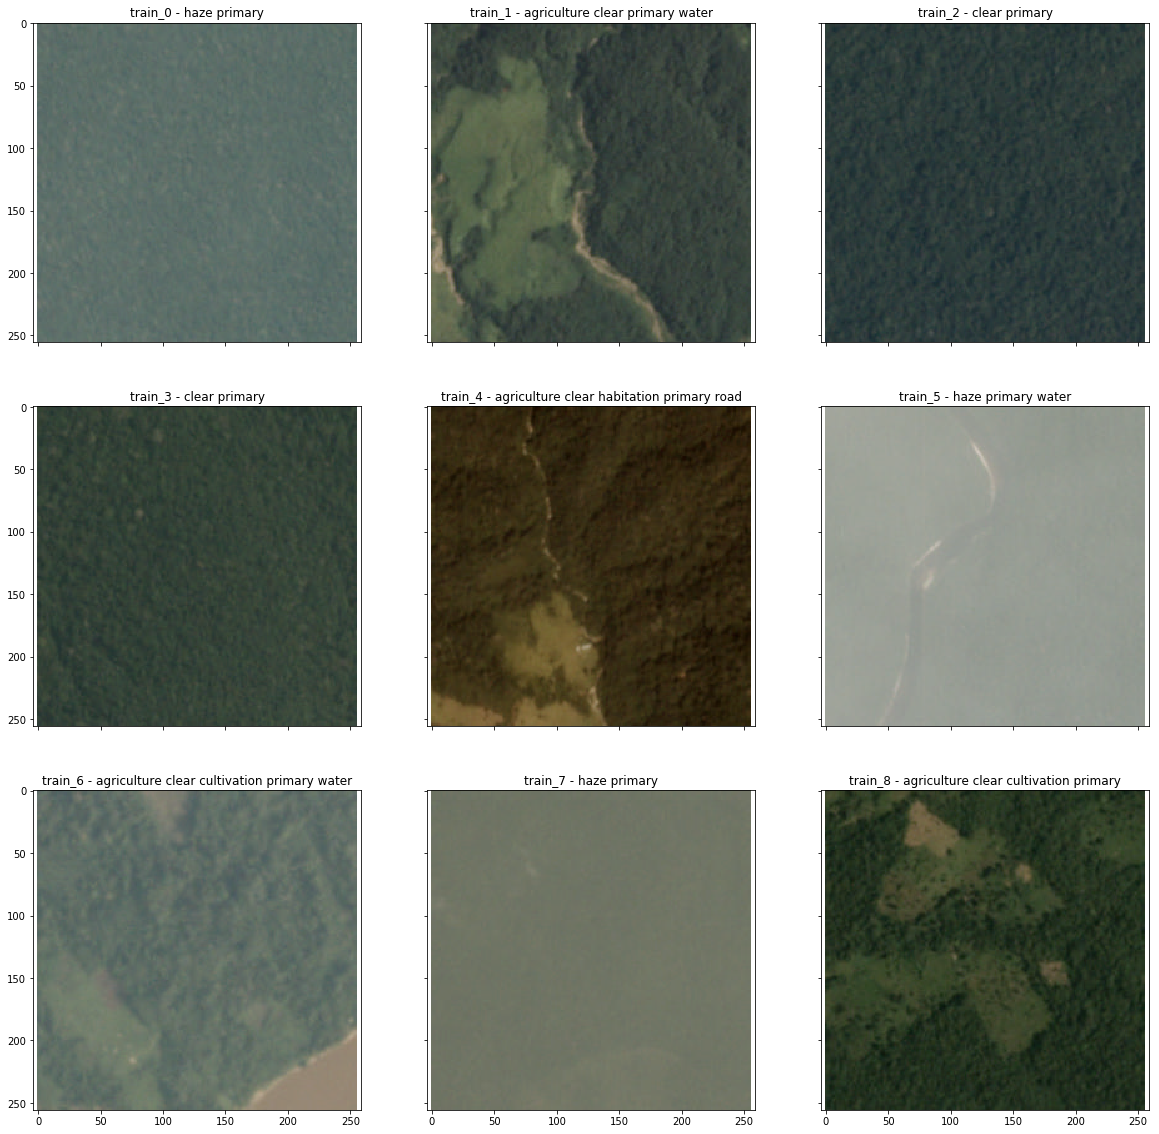

In [21]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train[:9].values:
    img = cv2.imread(f'{IMG_PATH}{f}{IMG_EXT}')
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title(f'{f} - {l}')
#     ax[i // 4, i % 4].imshow()
    i += 1

In [22]:
labels = df_train['tags'].apply(lambda x: x.split(' '))

In [23]:
counts = defaultdict(int)
for x in labels:
    for x_ in x:
        counts[x_] += 1

In [27]:
counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

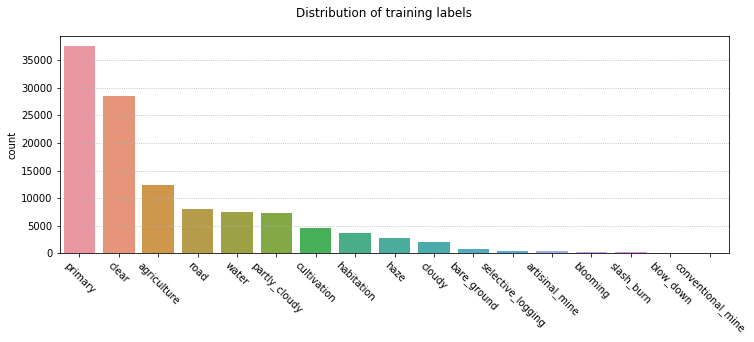

In [30]:
fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(12,4)
fig.suptitle('Distribution of training labels')
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-45);
ax.grid(True, axis='y', ls=':')
fig.savefig('labels')

In [154]:
# plt.figure(figsize=(10,5))
# plt.xticks(rotation=60)
# plt.suptitle('Distribution of training labels')
# plt.grid(True, axis='y', ls=':')
# plt.bar(counts.keys(), counts.values())
# plt.savefig('labels')

In [25]:
com = np.zeros([len(counts)]*2)
for i, v in enumerate(list(counts.keys())):
    for i_, v_ in enumerate(list(counts.keys())):
        c = 0; c_y = 0
        for row in labels.values:
            if v in row:
                c += 1
                if v_ in row:
                    c_y += 1
        com[i, i_] = c_y / c

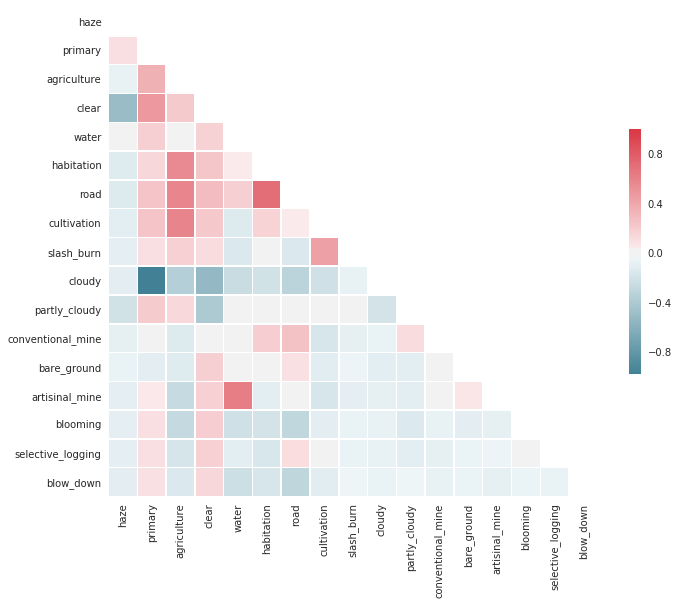

In [79]:
pd_com = pd.DataFrame(com, columns=counts.keys())
corr = pd_com.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('heatmap')

In [179]:
import cv2

n_imgs = 1000

all_imgs = []

for i in range(n_imgs):
    img = plt.imread(IMG_PATH + os.listdir(IMG_PATH)[i])
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype('float')
#    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype('float')
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    all_imgs.append(img)

img_mat = np.vstack(all_imgs)
img_mat.shape

(1000, 40000)

(1000, 1000)


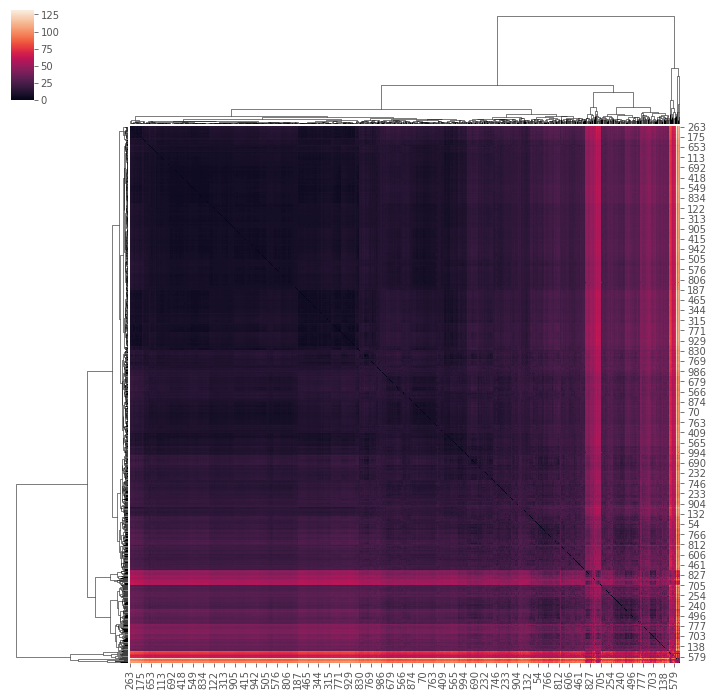

In [180]:
from scipy.spatial.distance import pdist, squareform

sq_dists = squareform(pdist(img_mat))
print(sq_dists.shape)
sns.clustermap(sq_dists, figsize=(12,12))
plt.savefig('../images/cluster')

In [181]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', random_state=101, 
            method='barnes_hut', n_iter=500, verbose=2).fit_transform(img_mat)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.005693
[t-SNE] Iteration 25: error = 1.1842660, gradient norm = 0.0168765
[t-SNE] Iteration 50: error = 1.1368544, gradient norm = 0.0160825
[t-SNE] Iteration 75: error = 0.8090939, gradient norm = 0.0074234
[t-SNE] Iteration 100: error = 0.8244693, gradient norm = 0.0074615
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.824469
[t-SNE] Iteration 125: error = 0.7557560, gradient norm = 0.0030359
[t-SNE] Iteration 150: error = 0.7550343, gradient norm = 0.0035866
[t-SNE] Iteration 175: error = 0.7610182, gradient norm = 0.0034702
[t-SNE] Iteration 200: error = 0.7593775, gradient norm = 0.0036373
[t-SNE] Iteration 200: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 200 iterations: 0.824469


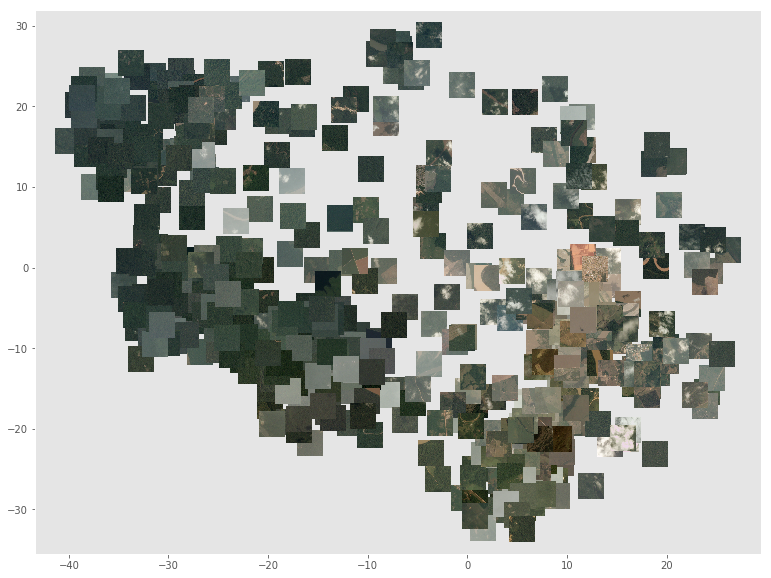

In [186]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, images, ax=None, zoom=0.1):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    #return artists

nimgs = 500
plt.figure(figsize=(13,10))
imscatter(tsne[0:nimgs,0], 
          tsne[0:nimgs,1],
          [plt.imread(IMG_PATH + os.listdir(IMG_PATH)[i]) for i in range(nimgs)])

plt.savefig('../images/TSNE')

/home/clu/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


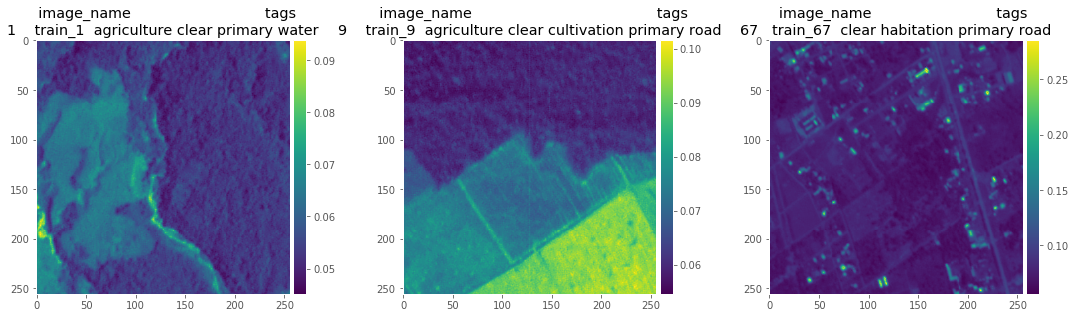

In [172]:
import skimage
import skimage.io

TIF_PATH_1 = '/data/amazon/train-tif-v2/train_1.tif'
TIF_PATH_9 = '/data/amazon/train-tif-v2/train_9.tif'
TIF_PATH_67 = '/data/amazon/train-tif-v2/train_67.tif'

im1g = skimage.io.imread(TIF_PATH_1, plugin='tifffile', as_grey=True)
im9g = skimage.io.imread(TIF_PATH_9, plugin='tifffile', as_grey=True)
im67g = skimage.io.imread(TIF_PATH_67, plugin='tifffile', as_grey=True)

new_style = {'grid': False}
plt.rc('axes', **new_style)
plt.subplots(1, 1, sharex='col', sharey='row', figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title('{}'.format(df_train[df_train.image_name == 'train_1']))
skimage.io.imshow(im1g)
plt.subplot(1, 3, 2)
plt.title('{}'.format(df_train[df_train.image_name == 'train_9']))
skimage.io.imshow(im9g)
plt.subplot(1, 3, 3)
plt.title('{}'.format(df_train[df_train.image_name == 'train_67']))
skimage.io.imshow(im67g)
plt.savefig('rawtif')

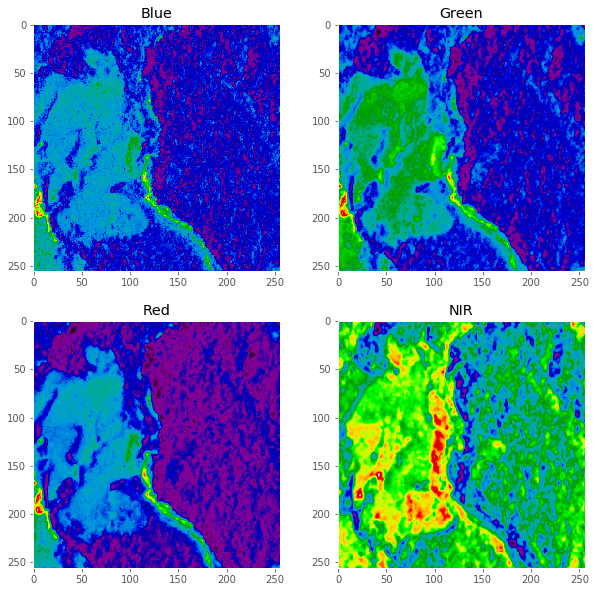

In [156]:
im1 = skimage.io.imread(TIF_PATH_1, plugin='tifffile')
im9 = skimage.io.imread(TIF_PATH_9, plugin='tifffile')
im67 = skimage.io.imread(TIF_PATH_67, plugin='tifffile')

fig, axes = plt.subplots(2,2, figsize=(10, 10))
ax = axes.ravel()

ax[0] = plt.subplot(2, 2, 1, adjustable='box-forced')
ax[0].imshow(im1[:,:,0], cmap='nipy_spectral')
for i in range(3):
    ax[i+1] = plt.subplot(2, 2, i+2, sharex=ax[0], sharey=ax[0], adjustable='box-forced')
    ax[i+1].imshow(im1[:,:,i+1], cmap='nipy_spectral')
    
ax[0].set_title('Blue')
ax[1].set_title('Green')
ax[2].set_title('Red')
ax[3].set_title('NIR')
plt.savefig('RGB-1')

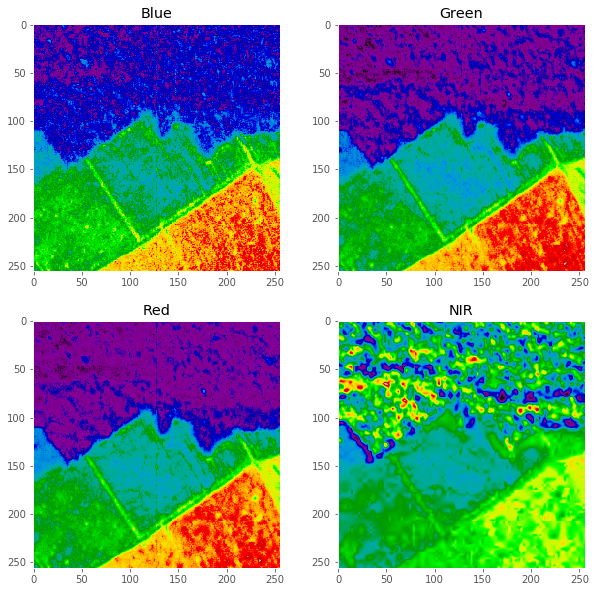

In [157]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))
ax = axes.ravel()

ax[0] = plt.subplot(2, 2, 1, adjustable='box-forced')
ax[0].imshow(im9[:,:,0], cmap='nipy_spectral')
for i in range(3):
    ax[i+1] = plt.subplot(2, 2, i+2, sharex=ax[0], sharey=ax[0], adjustable='box-forced')
    ax[i+1].imshow(im9[:,:,i+1], cmap='nipy_spectral')
    
ax[0].set_title('Blue')
ax[1].set_title('Green')
ax[2].set_title('Red')
ax[3].set_title('NIR')
plt.savefig('RGB-9')

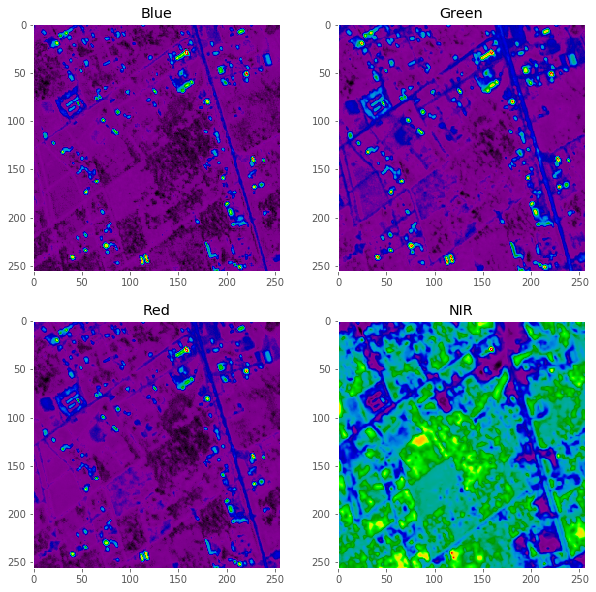

In [158]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))
ax = axes.ravel()

ax[0] = plt.subplot(2, 2, 1, adjustable='box-forced')
ax[0].imshow(im67[:,:,0], cmap='nipy_spectral')
for i in range(3):
    ax[i+1] = plt.subplot(2, 2, i+2, sharex=ax[0], sharey=ax[0], adjustable='box-forced')
    ax[i+1].imshow(im67[:,:,i+1], cmap='nipy_spectral')
    
ax[0].set_title('Blue')
ax[1].set_title('Green')
ax[2].set_title('Red')
ax[3].set_title('NIR')
plt.savefig('RGB-67')

In [130]:
from spectral import *

# RGB and False Color Images
im9RGB = get_rgb(im9, [2, 1, 0]) # RGB
im9NirRG = get_rgb(im9, [3, 2, 1]) # NIR-R-G
im9NirRB = get_rgb(im9, [3, 2, 0]) # NIR-R-B

# spectral module ndvi function
vi = ndvi(im9, 2, 3)

# reverse index
vi1 = (im9[:,:,3] - im9[:,:,2])/(im9[:,:,3] + im9[:,:,2])
#vi1 = (im3[:,:,0] - im3[:,:,1])/(im3[:,:,0] + im3[:,:,1])

# calculate NDVI and NDWI with spectral module adjusted bands
# (NIR - RED) / (NIR + RED)
vi2 = (im9NirRG[:, :, 0] - im9NirRG[:, :, 1])/(im9NirRG[:, :, 0] + im9NirRG[:, :, 1])
# (GREEN - NIR) / (GREEN + NIR)
vi3 = (im9NirRG[:, :, 2] - im9NirRG[:, :, 0])/(im9NirRG[:, :, 2] + im9NirRG[:, :, 0])

# EVI
evi = 2.5*((im9NirRG[:,:,0] - im9NirRG[:,:,1])/(im9NirRG[:,:,0] + 2.4*im9NirRG[:,:,1] + 1))

# SAVI
savi = ((im9NirRG[:,:,0] - im9NirRG[:,:,1])/(im9NirRG[:,:,0] + im9NirRG[:,:,1] +0.5)) * (1 + 0.5)

# MSAVI Modified Soil Adjusted Vegetation Index 
msavi = (2*im9NirRG[:,:,0] + 1 - np.sqrt(np.square(2*im9NirRG[:,:,0] + 1) - 8*(im9NirRG[:,:,0] - im9NirRG[:,:,1])) )

# NIR Index
mean_vis = np.mean(im9RGB, axis=2)
niri = (mean_vis - im9NirRG[:,:,0])/(mean_vis + im9NirRG[:,:,0])

# Simple Kmeans clustering from BGRN image
(simple_map, _) = kmeans(im9, 3, 10);

Initializing clusters along diagonal of N-dimensional bounding box.
Iteration 1...  0.Iteration 1...43100 pixels reassigned.
Iteration 2...  0.Iteration 2...14451 pixels reassigned.
Iteration 3...  0.Iteration 3...552 pixels reassigned.
Iteration 4...  0.Iteration 4...52 pixels reassigned.
Iteration 5...  0.Iteration 5...12 pixels reassigned.
Iteration 6...  0.Iteration 6...2 pixels reassigned.
Iteration 7...  0.Iteration 7...0 pixels reassigned.
kmeans terminated with 3 clusters after 6 iterations.


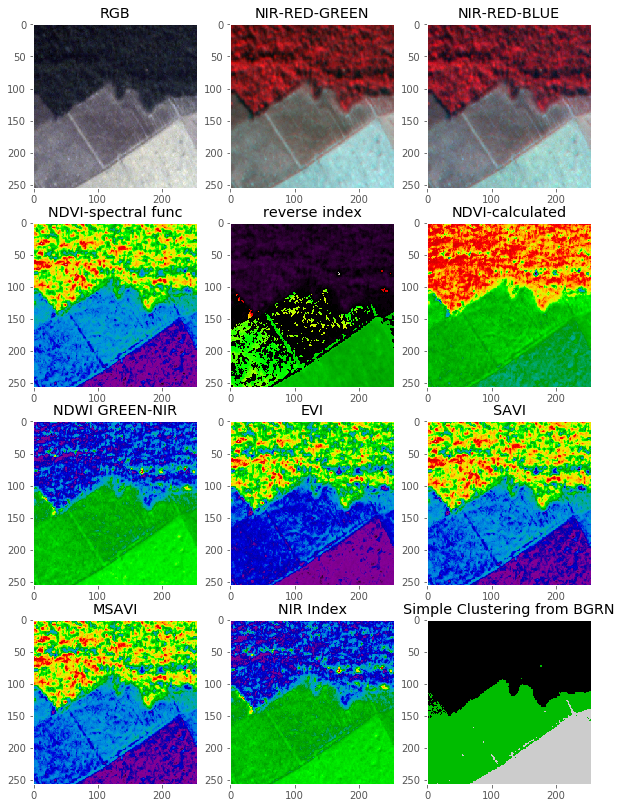

In [160]:
# plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 14))
ax = axes.ravel()

ax[0] = plt.subplot(4, 3, 1, adjustable='box-forced')
ax[1] = plt.subplot(4, 3, 2, sharex=ax[0], sharey=ax[0], adjustable='box-forced')
ax[2] = plt.subplot(4, 3, 3, sharex=ax[0], sharey=ax[0], adjustable='box-forced')
for i in range(3,12):
    ax[i] = plt.subplot(4, 3, i+1, adjustable='box-forced')
    
ax[0].imshow(im9RGB)
ax[0].set_title('RGB')
ax[1].imshow(im9NirRG)
ax[1].set_title('NIR-RED-GREEN')
ax[2].imshow(im9NirRB)
ax[2].set_title('NIR-RED-BLUE')
ax[3].imshow(vi, cmap='nipy_spectral') 
ax[3].set_title('NDVI-spectral func')
ax[4].imshow(vi1, cmap='nipy_spectral') 
ax[4].set_title('reverse index')
ax[5].imshow(vi2, cmap='nipy_spectral') 
ax[5].set_title('NDVI-calculated')
ax[6].imshow(vi3, cmap='nipy_spectral') 
ax[6].set_title('NDWI GREEN-NIR')
ax[7].imshow(evi, cmap='nipy_spectral') 
ax[7].set_title('EVI')
ax[8].imshow(savi, cmap='nipy_spectral') 
ax[8].set_title('SAVI')
ax[9].imshow(msavi, cmap='nipy_spectral') 
ax[9].set_title('MSAVI')
ax[10].imshow(niri, cmap='nipy_spectral') 
ax[10].set_title('NIR Index')
ax[11].imshow(simple_map, cmap='nipy_spectral') 
ax[11].set_title('Simple Clustering from BGRN')
plt.savefig('panel')

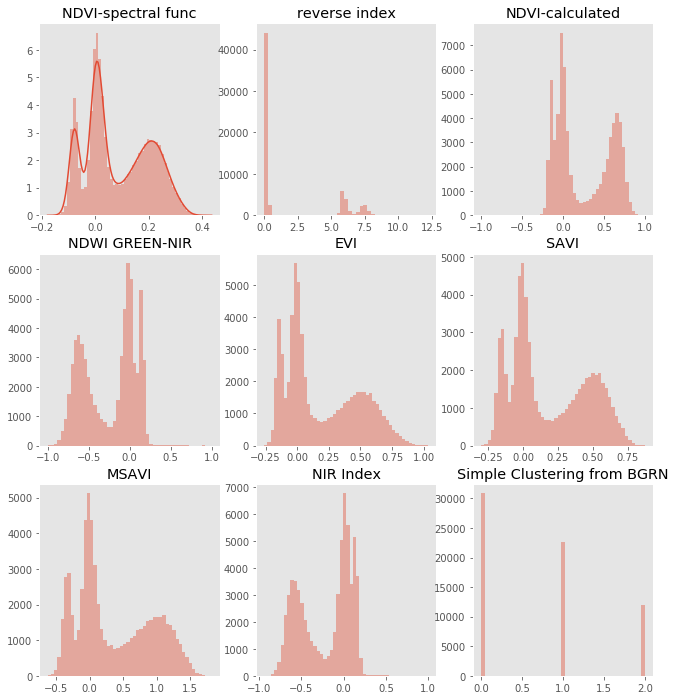

In [173]:
# image_maps = {
#     'NDVI_s':vi,
#     'Reverse':vi1,
#     'NDVI_c':vi2,
#     'NDWI':vi3,
#     'EVI':evi,
#     'SAVI':savi,
#     'MSAVI':msavi,
#     'NIRI':niri,
#     'Simple_class':simple_map
# }

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(11, 12))
ax = axes.ravel()

sns.distplot(vi.flatten(), kde=True, ax=ax[0])
sns.distplot(vi1.flatten(), kde=False, ax=ax[1])
sns.distplot(vi2.flatten(), kde=False, ax=ax[2])
sns.distplot(vi3.flatten(), kde=False, ax=ax[3])
sns.distplot(evi.flatten(), kde=False, ax=ax[4])
sns.distplot(savi.flatten(), kde=False, ax=ax[5])
sns.distplot(msavi.flatten(), kde=False, ax=ax[6])
sns.distplot(niri.flatten(), kde=False, ax=ax[7])
sns.distplot(simple_map.flatten(), kde=False, ax=ax[8])

ax[0].set_title('NDVI-spectral func')
ax[1].set_title('reverse index')
ax[2].set_title('NDVI-calculated')
ax[3].set_title('NDWI GREEN-NIR')
ax[4].set_title('EVI')
ax[5].set_title('SAVI')
ax[6].set_title('MSAVI')
ax[7].set_title('NIR Index')
ax[8].set_title('Simple Clustering from BGRN');
plt.savefig('density')

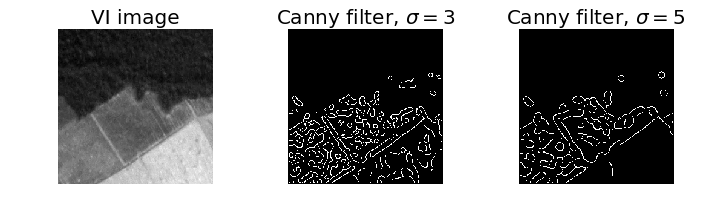

In [162]:
from skimage import feature

# Compute the Canny filter for two values of sigma
test_img = vi1
edges1 = feature.canny(test_img, sigma=3)
edges2 = feature.canny(test_img, sigma=5)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharex=True, sharey=True)

ax1.imshow(im9g, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('VI image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=3$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=5$', fontsize=20)

fig.tight_layout()
np.sum(edges1)
plt.savefig('edge')

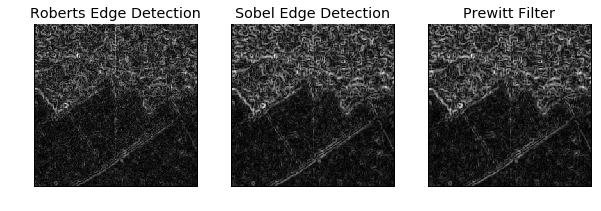

In [163]:
from skimage.filters import roberts, sobel, scharr, prewitt

test_img = vi

edge_roberts = roberts(test_img)
edge_sobel = sobel(test_img)
edge_prewitt = prewitt(test_img)

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(10, 3))

ax[0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_prewitt, cmap=plt.cm.gray)
ax[2].set_title('Prewitt Filter')

for a in ax:
    a.axis('off')
    
plt.savefig('EdgeDetection')

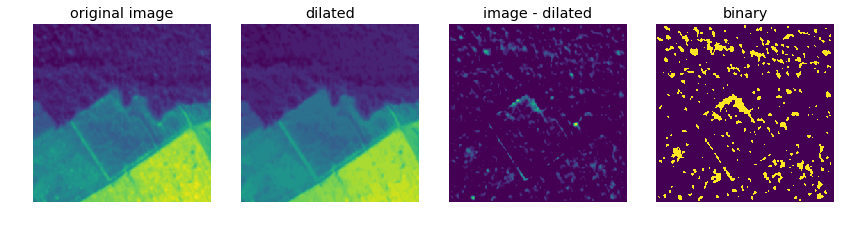

In [164]:
from scipy.ndimage import gaussian_filter
from skimage import img_as_float
from skimage.morphology import reconstruction
from skimage.filters import threshold_otsu

# Convert to float: Important for subtraction later which won't work with uint8
test_img = im9g
image = img_as_float(test_img)
image = gaussian_filter(image, 1)

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')
subtracted = image - dilated

thresh = threshold_otsu(subtracted)
binary = subtracted > thresh

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)

ax1.imshow(image)
ax1.set_title('original image')
ax1.axis('off')
ax1.set_adjustable('box-forced')

ax2.imshow(dilated, vmin=image.min(), vmax=image.max())
ax2.set_title('dilated')
ax2.axis('off')
ax2.set_adjustable('box-forced')

ax3.imshow(subtracted)
ax3.set_title('image - dilated')
ax3.axis('off')
ax3.set_adjustable('box-forced')

ax4.imshow(binary)
ax4.set_title('binary')
ax4.axis('off')
ax4.set_adjustable('box-forced')

fig.tight_layout()
plt.savefig('dilation')